<a href="https://colab.research.google.com/github/rafinchen/recommender_systems/blob/main/Modell-Based-Coll-Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/lucarenz1997/recommender_systems/blob/main/Modell-Based-Coll-Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modell-Based-Coll-Filtering
** Authors **: Rafaella and Luca

## Setup

In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from google.colab import drive
drive.mount('/content/drive')
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation

In [18]:
#Load data
data_sample_prep = pd.read_csv("/content/drive/MyDrive/Recommender/sample_preprocessed.csv")
data_sample_prep.head(100)

#Select Relevant Columns
data_sample_prep_sel = data_sample_prep[['user_id', 'media_id', 'is_listened']]  # Keep only necessary columns for the SVD model

In [ ]:
#Convert to Surprise Dataset Format
reader = Reader(rating_scale=(0, 1))  #Binary values (0 = not heard, 1 = heard)
data = Dataset.load_from_df(data_sample_prep_sel[['user_id', 'media_id', 'is_listened']], reader)

#Split training and test data
trainset, testset = train_test_split(data, test_size=0.2)

## Model Training and Predictions

In [19]:
#Initialize and train the SVD model
model = SVD(n_factors=50, reg_all=0.1, n_epochs=20)
model.fit(trainset)

#Generate Predictions on the Test Set
testset = trainset.build_testset()
predictions = model.test(testset)

## Threshold Optimization for F1 Score

In [20]:
#Optimize Threshold for Best F1 Score
best_threshold = 0.5
best_f1 = 0

#Test thresholds between 0.1 and 0.9
thresholds = np.arange(0.1, 1.0, 0.1)
for threshold in thresholds:
    y_true = [true_r for (_, _, true_r, _, _) in predictions]  # True labels
    y_pred = [1 if est >= threshold else 0 for (_, _, _, est, _) in predictions]  # Convert predictions to binary

    f1 = f1_score(y_true, y_pred, zero_division=1)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\n🔍 **Optimal Threshold for F1 Score: {best_threshold:.2f} with F1: {best_f1:.4f}**")


🔍 **Optimal Threshold for F1 Score: 0.50 with F1: 0.8680**


##  Model Evaluation

In [21]:
#Evaluate Model with Optimal Threshold
y_true = [true_r for (_, _, true_r, _, _) in predictions]
y_pred = [1 if est >= best_threshold else 0 for (_, _, _, est, _) in predictions]

accuracy_val = accuracy_score(y_true, y_pred)
precision_val = precision_score(y_true, y_pred, zero_division=1)
recall_val = recall_score(y_true, y_pred, zero_division=1)
f1_val = f1_score(y_true, y_pred, zero_division=1)

# **9. Print Evaluation Results**
print("\n🔎 **Model Evaluation with Optimal Threshold:**")
print(f"✅ Accuracy: {accuracy_val:.4f}")
print(f"✅ Precision: {precision_val:.4f}")
print(f"✅ Recall: {recall_val:.4f}")
print(f"✅ F1 Score: {f1_val:.4f}")


🔎 **Model Evaluation with Optimal Threshold:**
✅ Accuracy: 0.8050
✅ Precision: 0.8085
✅ Recall: 0.9368
✅ F1 Score: 0.8680


## Recommendations & Visualization

✅ Precision@10: 0.6820

🎵 **Top 10 Recommendations for User 123:**

1. Song ID: 14681034, Predicted Score: 0.606
2. Song ID: 14681034, Predicted Score: 0.606
3. Song ID: 14681034, Predicted Score: 0.606
4. Song ID: 125890447, Predicted Score: 0.557
5. Song ID: 3148015, Predicted Score: 0.549
6. Song ID: 2112595, Predicted Score: 0.523
7. Song ID: 16418245, Predicted Score: 0.498
8. Song ID: 97956122, Predicted Score: 0.489
9. Song ID: 1109835, Predicted Score: 0.486
10. Song ID: 94727052, Predicted Score: 0.484


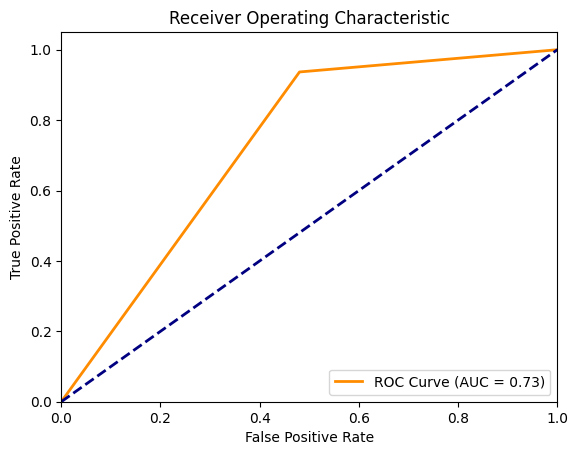

In [22]:
#Compute Precision@K
def precision_at_k(predictions, k=10, threshold=best_threshold):
    user_precisions = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        relevance = (est >= threshold)
        user_precisions[uid].append((est, relevance))

    precision_scores = []
    for uid, user_ratings in user_precisions.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]
        num_relevant = sum((relevance for _, relevance in top_k))
        precision = num_relevant / k
        precision_scores.append(precision)

    return np.mean(precision_scores) if precision_scores else 0

precision_k = precision_at_k(predictions, k=10)
print(f"✅ Precision@10: {precision_k:.4f}")

# **11. Generate Top-N Recommendations for Users**
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n_recommendations = get_top_n(predictions, n=10)

# **12. Display Top-10 Recommendations for a Sample User**
user_id = 123  # Example User ID
if user_id in top_n_recommendations:
    print(f"\n🎵 **Top 10 Recommendations for User {user_id}:**\n")
    for i, (song_id, score) in enumerate(top_n_recommendations[user_id], 1):
        print(f"{i}. Song ID: {song_id}, Predicted Score: {score:.3f}")
else:
    print(f"⚠ No recommendations for User {user_id}.")

# **13. ROC Curve and AUC Visualization**
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## ALS

## Data Preparation (ALS)

In [26]:
#Select Relevant Columns
data_sample_prep_sel = data_sample_prep[['user_id', 'media_id', 'is_listened']]  # Keep only necessary columns for the ALS model

#Convert IDs to Indices
user_ids = {id: idx for idx, id in enumerate(data_sample_prep_sel['user_id'].unique())}
media_ids = {id: idx for idx, id in enumerate(data_sample_prep_sel['media_id'].unique())}

data_sample_prep_sel['user_idx'] = data_sample_prep_sel['user_id'].map(user_ids)
data_sample_prep_sel['media_idx'] = data_sample_prep_sel['media_id'].map(media_ids)

#Create User-Item Interaction Matrix
user_item_matrix = csr_matrix(
    (data_sample_prep_sel['is_listened'], (data_sample_prep_sel['user_idx'], data_sample_prep_sel['media_idx']))
)

print(f"✅ User-Item Matrix Shape: {user_item_matrix.shape}")

✅ User-Item Matrix Shape: (14823, 67846)


## Train ALS Model

In [ ]:
#Train ALS Model
factors = 50
regularization = 0.1
iterations = 20
alpha = 40  # Scaling factor for implicit feedback

model = implicit.als.AlternatingLeastSquares(
    factors=factors,
    regularization=regularization,
    iterations=iterations
)

print("🚀 Training ALS model...")
model.fit(user_item_matrix * alpha)
print("✅ Model training complete.")

## Generate Predictions & Optimize Threshold

In [ ]:
#Generate Predictions
predictions = []
for user_idx in range(user_item_matrix.shape[0]):
    recommended = model.recommend(user_idx, user_item_matrix[user_idx], N=10)
    for media_idx, score in recommended:
        predictions.append((user_idx, media_idx, score))

print(f"✅ Predictions generated: {len(predictions)} records")

# **7. Optimize Threshold for Best F1 Score**
def optimize_threshold(y_true, y_scores):
    best_threshold = 0.5
    best_f1 = 0
    thresholds = np.arange(0.1, 1.0, 0.1)

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=1)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1


y_true = df['is_listened'].values
y_scores = np.array([score for _, _, score in predictions])

best_threshold, best_f1 = optimize_threshold(y_true, y_scores)

print(f"\n🔍 **Optimal Threshold for F1 Score: {best_threshold:.2f} with F1: {best_f1:.4f}**")


## Evaluate Model Performance

In [ ]:
#Evaluate Model
def evaluate_model(y_true, y_scores, threshold):
    y_pred = (y_scores >= threshold).astype(int)

    accuracy_val = accuracy_score(y_true, y_pred)
    precision_val = precision_score(y_true, y_pred, zero_division=1)
    recall_val = recall_score(y_true, y_pred, zero_division=1)
    f1_val = f1_score(y_true, y_pred, zero_division=1)

    print("\n🔎 **Model Evaluation with Optimized Threshold:**")
    print(f"✅ Accuracy: {accuracy_val:.4f}")
    print(f"✅ Precision: {precision_val:.4f}")
    print(f"✅ Recall: {recall_val:.4f}")
    print(f"✅ F1 Score: {f1_val:.4f}")


evaluate_model(y_true, y_scores, best_threshold)


# **9. Compute Precision@K**
def precision_at_k(predictions, k=10, threshold=best_threshold):
    user_precisions = defaultdict(list)
    for uid, _, score in predictions:
        relevance = (score >= threshold)
        user_precisions[uid].append((score, relevance))

    precision_scores = []
    for uid, user_ratings in user_precisions.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]
        num_relevant = sum((relevance for _, relevance in top_k))
        precision = num_relevant / k
        precision_scores.append(precision)

    return np.mean(precision_scores) if precision_scores else 0


precision_k = precision_at_k(predictions, k=10)
print(f"✅ Precision@10: {precision_k:.4f}")


## Generate Recommendations & Visualize ROC Curve

In [ ]:
#Generate Recommendations for a Specific User
def recommend_for_user(user_id, n=10):
    if user_id not in user_ids:
        print(f"⚠ User ID {user_id} not found.")
        return []

    user_idx = user_ids[user_id]
    recommendations = model.recommend(user_idx, user_item_matrix[user_idx], N=n)
    recommended_items = [(media_id, score) for media_id, score in recommendations]

    print(f"\n🎵 **Top {n} Recommendations for User {user_id}:**")
    for i, (media_id, score) in enumerate(recommended_items, 1):
        print(f"{i}. Media ID: {media_id}, Predicted Score: {score:.3f}")

    return recommended_items


# **Example Recommendation for a User**
user_id = 123  # Replace with a valid user ID
recommend_for_user(user_id, n=10)


# **11. Plot ROC Curve**
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


plot_roc_curve(y_true, y_scores)
